## Описание проекта



Обучите различные модели классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

Алгоритм решения выглядит так:
    
1. Загрузите и подготовьте данные.

2. Обучите различные модели нейронных сетей, в том числе рекуррентные.

3. Сделайте выводы.

### Описание данных

Данные находятся в файле `toxic_comments.csv`.

Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pymystem3 import Mystem
import re

import numpy as np
import pandas as pd
from tqdm import notebook

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer



2024-11-27 00:02:58.154075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

import nltk

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [6]:
# Прочитаем файл с данными в переменную df и изучим их
df = pd.read_csv('/Users/nikitafedorov/-ML/ml3/toxic_comments.csv', index_col=0)

df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [7]:
# общая информация методом info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Датасет состоит из 159292 записей. В столбце `text` представлен комментариями пользователей, в столбце `toxic` указана метка токсичности соответствующего высказывания.

In [8]:
# доля пропусков
df.isnull().mean()

text     0.0
toxic    0.0
dtype: float64

In [9]:
# число дубликатов
df.duplicated().sum()

0

Датасет не содержит пропущенных значений и явных дубликатов.

In [10]:
# Определим количество записей каждого класса
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Датасет не является сбалансированным, количество объектов класса 0 значительно превышает (почти в 9 раз) количество объектов класса 1. Это как правило не приводит к высокой обощающей способности алгоритмов.

Метрика accuracy будет некорректно отражать качество классификации. В таких случаях лучше использовать `f`-меру. Для бинарной классификации оценку качества обощающей способности алгоритма также эффективно оценивать по метрике `ROC-AUC`.

Алгоритм подготовки данных для векторизации.

1. Приведём кодировку символов к `Unicode` (для русскоязычных текстов)

2. Проведём лемматизацию слов

3. Удалим пунктуацию и лишние пробелы

4. Удалим стоп-слова (пока загрузим список, удалять будем в процессе `tf-idf` векторизации)

<div class="alert alert-block alert-warning">
<b>Замечание:</b> В данном случае приводить кодировку символов к `Unicode` нет необходимости, т.к. текст на английском языке.
    Для текста на русском языке используем следующий код:
    
    corpus = df['text'].values.astype('U')
</div>


In [11]:
corpus = df['text'].values
corpus

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [12]:
lemmatizer = WordNetLemmatizer() # Лемматизатор WordNetLemmatizer применяют к словам, а не ко всему тексту сразу

# Функция для лемматизации

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])

In [13]:
# Функция для устранения лишних пробелов и пунктуации
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [14]:
# Проведем лемматизацию
df['lemm_text'] = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]

In [15]:
df['lemm_text']

0         Explanation Why the edits made under my userna...
1         D aww He match this background colour I m seem...
2         Hey man I m really not trying to edit war It s...
3         More I can t make any real suggestion on impro...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159446    And for the second time of asking when your vi...
159447    You should be ashamed of yourself That is a ho...
159448    Spitzer Umm there no actual article for prosti...
159449    And it look like it wa actually you who put on...
159450    And I really don t think you understand I came...
Name: lemm_text, Length: 159292, dtype: object

In [16]:
# сформируем список стоп-слов
stopwords = list(nltk_stopwords.words('english'))


Выделим признак и целевой признак (класс). Разделим данные на обучающую и тестовую выборки в соотношении 4:1.

In [17]:
X = df['lemm_text']
y = df['toxic']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=145, stratify = y)

print('Размерность обучающего набора',X_train.shape)
print('Размерность тестового набора',X_test.shape)

Размерность обучающего набора (127433,)
Размерность тестового набора (31859,)


## Обучение моделей

При обучении моделей будем использовать метрику `F1`.

Сформируйте векторные представления признаков для обучения моделей. Подберите параметры алгоритмов, проведите обучение и тестирование всех построенных моделей.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

## Тестирование модели

In [41]:
cvector = CountVectorizer()
cvector.fit(X_train)

X_train_cvector = cvector.transform(X_train)
X_test_cvector = cvector.transform(X_test)

In [44]:
lg = LogisticRegression(random_state=42)
lg.fit(X_train_cvector, y_train)
f1_score(lg.predict(X_test_cvector), y_test), roc_auc_score(lg.predict(X_test_cvector), y_test)

(0.758608874421792, 0.9082874302975811)

In [46]:
mnb = MultinomialNB()
mnb.fit(X_train_cvector, y_train)
f1_score(mnb.predict(X_test_cvector), y_test), roc_auc_score(mnb.predict(X_test_cvector), y_test)

(0.714475873544093, 0.8683883195137719)

***TfidfVectorizer***

In [74]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [75]:
lg_td = LogisticRegression()
lg_td.fit(X_train_tfidf, y_train)
f1_score(lg_td.predict(X_test_tfidf), y_test), roc_auc_score(lg_td.predict(X_test_tfidf), y_test)

(0.7435944700460829, 0.9403644227674897)

In [76]:
mnb_td = MultinomialNB(alpha=0.001)
mnb_td.fit(X_train_tfidf, y_train)
f1_score(mnb_td.predict(X_test_tfidf), y_test), roc_auc_score(mnb_td.predict(X_test_tfidf), y_test)

(0.6447267128560431, 0.901393636436582)

In [77]:
# Матрица ошибок
confusion_matrix(lg_td.predict(X_test_tfidf), y_test)

array([[28451,  1220],
       [  171,  2017]])

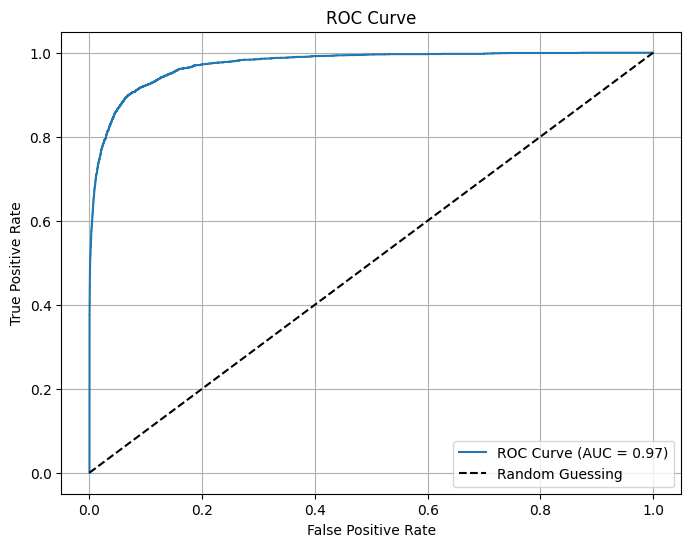

In [78]:
# ROC-кривые построенных моделей
y_pred_prob = lg_td.predict_proba(X_test_tfidf)[:, 1]  # Вероятности для класса 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")  # Линия случайной классификации
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Напишите произвольные два комментария: положительный и отрицательный. Выясните, как их классифицировала Ваша модель.

## Выводы

Сделайте выводы о качестве построенных моделей, о влиянии параметров алгоритмов на качество их обучения. Укажите, какая модель показала лучший результат.